====================================================================================================

**Molecular data and representation**



**ChEMBL database**

ChEMBL is an open large-scale bioactivity database, containing molecules with drug-like properties.

The recent release (version 25) contains information extracted from more than
 documents. In total, there are now more than
 million compounds and
 million bioactivity data points available.

It is maintained by European Bioinformatics Institute. Please refer to Talktorial T001 for more details.


**SMILES structures and rules**

SMILES (Simplified Molecular Input Line Entry System) notation is a chemical notation that allows a user to represent a chemical structure of a molecule in a linear way that can be read by the computer (see “Modern Aspects of the Smiles Rearrangement” (2017), Chemistry A European Journal, Volume23, Issue38, 8992-9008 for further information).

It contains a sequence of letters, numbers and characters that specify a molecule’s atoms, their connectivity, bond order and chirality.


Some SMILES specification rules

- Atoms - are represented by their atomic symbols. Also metal atoms are represented with symbols in square bracket, e.g. Gold [Au].

- Bonds - single, double and triple bonds are represented by symbols -, = and #, respectively. Single bonds are the default and therefore do not need to be specified.

- Aromaticity - While atomic symbols are generally used in upper case, such as C, O, S and N; to specify aromatic atoms lower case symbols are used instead, such as c, o, s and n. Sometimes implicit bonds in rings (alternating = and -) are also used to describe aromatic atoms such as C1=CC=CC=C1.

- Rings - SMILES allows a user to identify ring structures by using numbers to identify the opening and closing ring atom. For example, in C1CCCCC1, the first carbon has a number “1” which connects by a single bond with the last carbon which also has a number “1”. The resulting structure is cyclohexane.

- Branches - are specified by enclosing them in parentheses, and can be nested or arranged. For example, 2-Propanol is represented by CC(O)C.


references : https://projects.volkamerlab.org/teachopencadd/talktorials/T021_one_hot_encoding.html

=======================================================================================================

In [1]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 17.3 MB/s eta 0:00:00


In [2]:
from pathlib import Path
from warnings import filterwarnings

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, PandasTools
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt

# Silence some expected warnings
filterwarnings("ignore")

In [3]:
# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [5]:
df = pd.read_csv("BBBP.csv", index_col=0).reset_index(drop=True)
print(f"Shape of dataframe: {df.shape}\n")
# NBVAL_CHECK_OUTPUT

Shape of dataframe: (2050, 3)



In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    2050 non-null   object
 1   p_np    2050 non-null   int64 
 2   smiles  2050 non-null   object
dtypes: int64(1), object(2)
memory usage: 48.2+ KB


In [7]:
df.head(3)
# NBVAL_CHECK_OUTPUT

,name,p_np,smiles
0,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...


In [8]:
df = df[["name", "smiles"]]

[16:54:48] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:54:48] WARNING: not removing hydrogen atom without neighbors
[16:54:48] Explicit valence for atom # 6 N, 4, is greater than permitted
[16:54:48] WARNING: not removing hydrogen atom without neighbors
[16:54:48] WARNING: not removing hydrogen atom without neighbors
[16:54:48] WARNING: not removing hydrogen atom without neighbors
[16:54:48] WARNING: not removing hydrogen atom without neighbors
[16:54:48] WARNING: not removing hydrogen atom without neighbors
[16:54:48] WARNING: not removing hydrogen atom without neighbors
[16:54:48] Explicit valence for atom # 6 N, 4, is greater than permitted
[16:54:48] WARNING: not removing hydrogen atom without neighbors
[16:54:48] WARNING: not removing hydrogen atom without neighbors
[16:54:48] WARNING: not removing hydrogen atom without neighbors
[16:54:48] WARNING: not removing hydrogen atom without neighbors
[16:54:48] Explicit valence for atom # 11 N, 4, is greater than pe

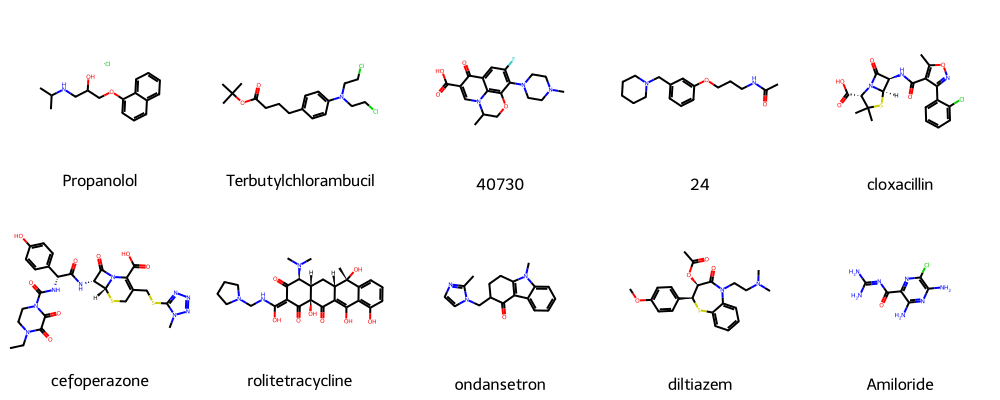

In [9]:
# Using PandasTools and the respective Draw method
PandasTools.AddMoleculeColumnToFrame(df, smilesCol="smiles", molCol="Mol2D")
Draw.MolsToGridImage(list(df.Mol2D[0:10]), legends=list(df.name[0:20]), molsPerRow=5)

In [10]:
def assess_two_letter_elements(df):
    """
    Find the two letter elements in dataframe.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe which requires preprocessing.

    Returns
    -------
    two_letter_elements : list
        List with found two letter elements
    """

    # Search for unique characters in SMILES strings
    unique_chars = set(df.smiles.apply(list).sum())
    # Get upper and lower case letters only
    upper_chars = []
    lower_chars = []
    for entry in unique_chars:
        if entry.isalpha():
            if entry.isupper():
                upper_chars.append(entry)
            elif entry.islower():
                lower_chars.append(entry)
    print(f"Upper letter characters {sorted(upper_chars)}")
    print(f"Lower letter characters {sorted(lower_chars)}")

    # List of all possible periodic elements
    periodic_elements = [
        "Ac",
        "Al",
        "Am",
        "Sb",
        "Ar",
        "As",
        "At",
        "Ba",
        "Bk",
        "Be",
        "Bi",
        "Bh",
        "B",
        "Br",
        "Cd",
        "Ca",
        "Cf",
        "C",
        "Ce",
        "Cs",
        "Cl",
        "Cr",
        "Co",
        "Cn",
        "Cu",
        "Cm",
        "Ds",
        "Db",
        "Dy",
        "Es",
        "Er",
        "Eu",
        "Fm",
        "Fl",
        "F",
        "Fr",
        "Gd",
        "Ga",
        "Ge",
        "Au",
        "Hf",
        "Hs",
        "He",
        "Ho",
        "H",
        "In",
        "I",
        "Ir",
        "Fe",
        "Kr",
        "La",
        "Lr",
        "Pb",
        "Li",
        "Lv",
        "Lu",
        "Mg",
        "Mn",
        "Mt",
        "Md",
        "Hg",
        "Mo",
        "Mc",
        "Nd",
        "Ne",
        "Np",
        "Ni",
        "Nh",
        "Nb",
        "N",
        "No",
        "Og",
        "Os",
        "O",
        "Pd",
        "P",
        "Pt",
        "Pu",
        "Po",
        "K",
        "Pr",
        "Pm",
        "Pa",
        "Ra",
        "Rn",
        "Re",
        "Rh",
        "Rg",
        "Rb",
        "Ru",
        "Rf",
        "Sm",
        "Sc",
        "Sg",
        "Se",
        "Si",
        "Ag",
        "Na",
        "Sr",
        "S",
        "Ta",
        "Tc",
        "Te",
        "Ts",
        "Tb",
        "Tl",
        "Th",
        "Tm",
        "Sn",
        "Ti",
        "W",
        "U",
        "V",
        "Xe",
        "Yb",
        "Y",
        "Zn",
        "Zr",
    ]

    # The two_char_elements list contains all two letter elements
    # which can be generated by all possible combination of upper x lower characters
    # and are valid periodic elements.
    two_char_elements = []
    for upper in upper_chars:
        for lower in lower_chars:
            ch = upper + lower
            if ch in periodic_elements:
                two_char_elements.append(ch)

    # This list is then reduced to the subset of two-letter elements
    # that actually appear in the SMILES strings, specific to our data set.
    two_char_elements_smiles = set()
    for char in two_char_elements:
        if df.smiles.str.contains(char).any():
            two_char_elements_smiles.add(char)

    return two_char_elements_smiles

In [11]:
elements_found = assess_two_letter_elements(df)
print(f"\nTwo letter elements found in the data set: {sorted(elements_found)}")
# NBVAL_CHECK_OUTPUT

Upper letter characters ['B', 'C', 'F', 'H', 'I', 'N', 'O', 'P', 'S']
Lower letter characters ['a', 'c', 'l', 'n', 'o', 'r', 's']

Two letter elements found in the data set: ['Br', 'Ca', 'Cl', 'Cn', 'Na', 'Sc']


In [12]:
replace_dict = {"Cl": "L", "Br": "R", "Se": "X", "@@": "Z"}

In [13]:
def preprocessing_data(df, replacement):
    """
    Preprocess the SMILES structures in a data set.

    Parameters
    ----------
    df : pandas.DataFrame
      Dataframe which requires preprocessing.
    replacement : dict
      Dictionary with mapping for replacement.

    Returns
    -------
    df : pandas.DataFrame
        Dataframe with new processed canonical SMILES column.
    unique_char : list
        List with unique characters present in SMILES.
    """
    # Print warning if the data set has a 'Sc' element
    if df.smiles.str.contains("Sc").any():
        print(
            'Warning: "Sc" element is found in the data set, since the element is rarely found '
            "in the drugs so we are not converting  "
            'it to single letter element, instead considering "S" '
            'and "c" as separate elements. '
        )

    # Create a new column having processed canonical SMILES
    df["processed_smiles"] = df["smiles"].copy()

    # Replace the two letter elements found with one character
    for pattern, repl in replacement.items():
        df["processed_smiles"] = df["processed_smiles"].str.replace(
            pattern, repl
        )

    unique_char = set(df.processed_smiles.apply(list).sum())
    return df, unique_char

In [14]:
# Calling function
df, unique_char = preprocessing_data(df, replace_dict)
df.head(3)

,name,smiles,Mol2D,processed_smiles
0,Propanolol,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x7a4bf45fc6d0>,[L].CC(C)NCC(O)COc1cccc2ccccc12
1,Terbutylchlorambucil,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,<rdkit.Chem.rdchem.Mol object at 0x7a4bf45fc9e0>,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCL)CCL
2,40730,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,<rdkit.Chem.rdchem.Mol object at 0x7a4bf45fca50>,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...


In [15]:
# Index of the longest SMILES string
longest_smiles = max(df["smiles"], key=len)
longest_smiles_index = df.smiles[df.smiles == longest_smiles].index.tolist()
print(f"Longest SMILES: {longest_smiles}")
print(f"Contains {len(longest_smiles)} characters, index in dataframe: {longest_smiles_index[0]}.")
smiles_maxlen = len(longest_smiles)
# NBVAL_CHECK_OUTPUT

Longest SMILES: CCC(C)[C@H]1O[C@]2(CC[C@@H]1C)CC3C[C@@H](C\C=C(C)\[C@@H](O[C@H]4C[C@H](OC)[C@@H](OC5C[C@H](OC)[C@@H](O)[C@H](C)O5)[C@H](C)O4)[C@@H](C)/C=C/C=C/6CO[C@@H]7[C@H](O)C(=C[C@@H](C(=O)O3)[C@]67O)C)O2.CO[C@H]8CC(O[C@@H](C)[C@@H]8O)O[C@H]9[C@H](C)O[C@H](C[C@@H]9OC)O[C@H]/%10[C@@H](C)/C=C/C=C/%11CO[C@@H]%12[C@H](O)C(=C[C@@H](C(=O)OC%13C[C@@H](C\C=C%10C)O[C@@]%14(CC[C@H](C)[C@H](O%14)C(C)C)C%13)[C@]%11%12O)C
Contains 400 characters, index in dataframe: 826.


In [16]:
# Index of the shortest SMILES string
shortest_smiles = min(df["smiles"], key=len)
shortest_smiles_index = df.smiles[df.smiles == shortest_smiles].index.tolist()
print(f"Shortest SMILES: {shortest_smiles}")
print(
    f"Contains {len(shortest_smiles)} characters, index in dataframe: {shortest_smiles_index[0]}."
)
# NBVAL_CHECK_OUTPUT

Shortest SMILES: CCO
Contains 3 characters, index in dataframe: 454.


In [17]:
# Function defined to create one-hot encoded matrix
def smiles_encoder(smiles, max_len, unique_char):
    """
    Function defined using all unique characters in our
    processed canonical SMILES structures created
    with the preprocessing_data function.

    Parameters
    ----------
    smiles : str
         SMILES of a molecule in string format.
    unique_char : list
         List of unique characters in the string data set.
    max_len : int
         Maximum length of the SMILES string.

    Returns
    -------
    smiles_matrix : numpy.ndarray
         One-hot encoded matrix of fixed shape
         (unique char in smiles, max SMILES length).
    """
    # create dictionary of the unique char data set
    smi2index = {char: index for index, char in enumerate(unique_char)}
    # one-hot encoding
    # zero padding to max_len
    smiles_matrix = np.zeros((len(unique_char), max_len))
    for index, char in enumerate(smiles):
        smiles_matrix[smi2index[char], index] = 1
    return smiles_matrix

In [18]:
# Apply the function to the processed canonical SMILES strings
df["unique_char_ohe_matrix"] = df["processed_smiles"].apply(
    smiles_encoder, max_len=smiles_maxlen, unique_char=unique_char
)
df.head(3)

,name,smiles,Mol2D,processed_smiles,unique_char_ohe_matrix
0,Propanolol,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x7a4bf45fc6d0>,[L].CC(C)NCC(O)COc1cccc2ccccc12,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,Terbutylchlorambucil,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,<rdkit.Chem.rdchem.Mol object at 0x7a4bf45fc9e0>,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCL)CCL,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,40730,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,<rdkit.Chem.rdchem.Mol object at 0x7a4bf45fca50>,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [19]:
df["unique_char_ohe_matrix"]

0       [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1       [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2       [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3       [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
4       [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
                              ...                        
2045    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2046    [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...
2047    [[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2048    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2049    [[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: unique_char_ohe_matrix, Length: 2050, dtype: object

In [20]:
def one_hot_matrix_plot(ohe_matrix, smiles_char, smiles):
    """
    Visualize one-hot encoded matrix
    using matplotlib imshow() function.

    Parameters
    ----------
    ohe_matrix : numpy.ndarray
       One-hot encoded (ohe) matrix of shape
       (`smiles_char`, `len(smiles)`).
    smiles_char : list
        List of all possible SMILES characters.
    smiles : string
        Original SMILES string of respective molecule.

    Returns
    ------
    None

    """
    im = plt.imshow(ohe_matrix, cmap="hot", interpolation="None")
    plt.xlabel("Length of SMILES string")
    plt.ylabel(f"Char in SMILES ({len(smiles_char)})")
    plt.title("Visualization of one-hot encoded matrix")
    plt.show()
    print("Shape of one-hot matrix : ", ohe_matrix.shape)
    print("Associated SMILES: ", smiles)
    return None

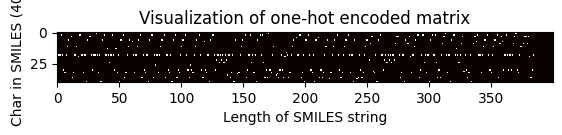

Shape of one-hot matrix :  (40, 400)
Associated SMILES:  CCC(C)[C@H]1O[C@]2(CC[C@@H]1C)CC3C[C@@H](C\C=C(C)\[C@@H](O[C@H]4C[C@H](OC)[C@@H](OC5C[C@H](OC)[C@@H](O)[C@H](C)O5)[C@H](C)O4)[C@@H](C)/C=C/C=C/6CO[C@@H]7[C@H](O)C(=C[C@@H](C(=O)O3)[C@]67O)C)O2.CO[C@H]8CC(O[C@@H](C)[C@@H]8O)O[C@H]9[C@H](C)O[C@H](C[C@@H]9OC)O[C@H]/%10[C@@H](C)/C=C/C=C/%11CO[C@@H]%12[C@H](O)C(=C[C@@H](C(=O)OC%13C[C@@H](C\C=C%10C)O[C@@]%14(CC[C@H](C)[C@H](O%14)C(C)C)C%13)[C@]%11%12O)C


In [21]:
# Pass the index of the longest SMILES string to visualize the matrix
one_hot_matrix_plot(
    df.iloc[longest_smiles_index[0]]["unique_char_ohe_matrix"], unique_char, longest_smiles
)

In [27]:
(df.iloc[longest_smiles_index[0]]["unique_char_ohe_matrix"]).shape

(40, 400)

==============================================================================================================================================================================

In [ ]:
#Dependencies
import numpy as np
import pandas as pd
#dataset import
dataset = pd.read_csv('BBBP.csv') #You need to change #directory accordingly
dataset.head(10) #Return 10 rows of data

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...
5,6,cefoperazone,1,CCN1CCN(C(=O)N[C@@H](C(=O)N[C@H]2[C@H]3SCC(=C(...
6,7,rolitetracycline,1,CN(C)[C@H]1[C@@H]2C[C@H]3C(=C(O)c4c(O)cccc4[C@...
7,8,ondansetron,1,Cn1c2CCC(Cn3ccnc3C)C(=O)c2c4ccccc14
8,9,diltiazem,1,COc1ccc(cc1)[C@@H]2Sc3ccccc3N(CCN(C)C)C(=O)[C@...
9,10,Amiloride,1,NC(N)=NC(=O)c1nc(Cl)c(N)nc1N


In [ ]:
#Changing pandas dataframe to numpy array
X = df.iloc[:,4].values
y = dataset.iloc[:,2].values

In [ ]:
print(X)
print(y)

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]) ...
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])
 arr

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1)

In [ ]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
# Neural network
model = Sequential()
model.add(Dense(16, input_dim=400, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=64)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

==================================================================================================================================================================================================

In [ ]:
class SMILESDataset_BBBP(Dataset):
    def __init__(self, data_path, data_length=None, shuffle=False):
        data = pd.read_csv("BBBP.csv")
        self.data = [data.iloc[i] for i in range(len(data)) if Chem.MolFromSmiles(data.iloc[i]['smiles'])]

        if shuffle: random.shuffle(self.data)
        if data_length is not None: self.data = self.data[data_length[0]:data_length[1]]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        smiles = Chem.MolToSmiles(Chem.MolFromSmiles(self.data[index]['smiles']), isomericSmiles=False)
        label = int(self.data[index]['p_np'])

        return '[CLS]' + smiles, label

TypeError: str() argument 'encoding' must be str, not tuple

In [ ]:
SMILESDataset_BBBP(Dataset)

NameError: name 'SMILESDataset_BBBP' is not defined

In [ ]:
import argparse
import torch
import numpy as np
from SPMM_models import SPMM
import torch.backends.cudnn as cudnn
from transformers import BertTokenizer, WordpieceTokenizer
from dataset import SMILESDataset_pretrain
from torch.utils.data import DataLoader
import random
import pickle
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


def generate(model, prop_input, text_embeds, text_atts):
    prop_embeds = model.property_encoder(inputs_embeds=prop_input, return_dict=True).last_hidden_state
    prob_atts = torch.ones(prop_input.size()[:-1], dtype=torch.long).to(prop_input.device)
    token_output = model.text_encoder.bert(encoder_embeds=prop_embeds,
                                           attention_mask=prob_atts,
                                           encoder_hidden_states=text_embeds,
                                           encoder_attention_mask=text_atts,
                                           return_dict=True,
                                           is_decoder=True,
                                           mode='fusion',
                                           ).last_hidden_state
    pred = model.property_mtr_head(token_output).squeeze(-1)[:, -1]
    return pred.unsqueeze(1)


@torch.no_grad()
def pv_generate(model, data_loader):
    # test
    with open('./normalize.pkl', 'rb') as w:
        mean, std = pickle.load(w)
    device = model.device
    tokenizer = model.tokenizer
    model.eval()
    print("SMILES-to-PV generation...")
    # convert list of string to dataloader
    if isinstance(data_loader, list):
        gather = []
        text_input = tokenizer(data_loader, padding='longest', truncation=True, max_length=100, return_tensors="pt").to(device)
        text_embeds = model.text_encoder.bert(text_input.input_ids[:, 1:], attention_mask=text_input.attention_mask[:, 1:],
                                              return_dict=True, mode='text').last_hidden_state
        prop_input = model.property_cls.expand(len(data_loader), -1, -1)
        prediction = []
        for _ in range(53):
            output = generate(model, prop_input, text_embeds, text_input.attention_mask[:, 1:])
            prediction.append(output)
            output = model.property_embed(output.unsqueeze(2))
            prop_input = torch.cat([prop_input, output], dim=1)

        prediction = torch.stack(prediction, dim=-1)
        for i in range(len(data_loader)):
            gather.append(prediction[i].cpu()*std + mean)
        return gather

    reference, candidate = [], []
    for (prop, text) in data_loader:
        text_input = tokenizer(text, padding='longest', truncation=True, max_length=100, return_tensors="pt").to(device)
        text_embeds = model.text_encoder.bert(text_input.input_ids[:, 1:], attention_mask=text_input.attention_mask[:, 1:],
                                              return_dict=True, mode='text').last_hidden_state
        prop_input = model.property_cls.expand(len(text), -1, -1)
        prediction = []
        for _ in range(53):
            output = generate(model, prop_input, text_embeds, text_input.attention_mask[:, 1:])
            prediction.append(output)
            output = model.property_embed(output.unsqueeze(2))
            prop_input = torch.cat([prop_input, output], dim=1)

        prediction = torch.stack(prediction, dim=-1)
        for i in range(prop.size(0)):
            reference.append(prop[i].cpu())
            candidate.append(prediction[i].cpu())
    print('SMILES-to-PV generation done')
    return reference, candidate


@torch.no_grad()
def metric_eval(ref, cand):
    with open('./normalize.pkl', 'rb') as w:
        norm = pickle.load(w)
    mean, std = norm
    mse = []
    n_mse = []
    rs, cs = [], []
    for i in range(len(ref)):
        r = (ref[i] * std) + mean
        c = (cand[i] * std) + mean
        rs.append(r)
        cs.append(c)
        mse.append((r - c) ** 2)
        n_mse.append((ref[i] - cand[i]) ** 2)
    mse = torch.stack(mse, dim=0)
    rmse = torch.sqrt(torch.mean(mse, dim=0)).squeeze()
    n_mse = torch.stack(n_mse, dim=0)
    n_rmse = torch.sqrt(torch.mean(n_mse, dim=0))
    print('mean of 53 properties\' normalized RMSE:', n_rmse.mean().item())

    rs = torch.stack(rs)
    cs = torch.stack(cs).squeeze()
    r2 = []
    for i in range(rs.size(1)):
        r2.append(r2_score(rs[:, i], cs[:, i]))
    r2 = np.array(r2)
    print('mean r^2 coefficient of determination:', r2.mean().item())

    plt.figure(figsize=(27, 27))
    with open('./property_name.txt', 'r') as f:
        names = [l.strip() for l in f.readlines()[:53]]
    for i, j in enumerate(range(53)):
        x = rs[:, j]
        y = cs[:, j]
        plt.subplot(9, 6, i + 1)
        plt.title(f'r2: {r2[j]:.3f}, RMSE: {rmse[j]:.3f}', fontdict={'fontsize': 9})
        plt.scatter(x, y, c='r', s=0.5, alpha=0.5, label=names[j])
        if i == 44:
            plt.xlim([-2, 2])
            plt.ylim([-2, 2])
        plt.rc('xtick', labelsize=7)
        plt.rc('ytick', labelsize=7)
        plt.legend(loc='upper left')
        plt.axline((0, 0), slope=1, color="#bbb", linestyle=(0, (5, 5)), zorder=-10)
    plt.show()


def main(args, config):
    device = torch.device(args.device)

    # fix the seed for reproducibility
    seed = random.randint(0, 1000)
    print('seed:', seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.benchmark = True

    # === Dataset === #
    print("Creating dataset")
    dataset_test = SMILESDataset_pretrain(args.input_file)
    test_loader = DataLoader(dataset_test, batch_size=config['batch_size_test'], pin_memory=True, drop_last=False)

    tokenizer = BertTokenizer(vocab_file=args.vocab_filename, do_lower_case=False, do_basic_tokenize=False)
    tokenizer.wordpiece_tokenizer = WordpieceTokenizer(vocab=tokenizer.vocab, unk_token=tokenizer.unk_token, max_input_chars_per_word=250)

    # === Model === #
    print("Creating model")
    model = SPMM(config=config, tokenizer=tokenizer, no_train=True)

    if args.checkpoint:
        print('LOADING PRETRAINED MODEL..')
        checkpoint = torch.load(args.checkpoint, map_location='cpu')
        state_dict = checkpoint['state_dict']

        for key in list(state_dict.keys()):
            if 'queue' in key:
                del state_dict[key]

        msg = model.load_state_dict(state_dict, strict=False)
        print('load checkpoint from %s' % args.checkpoint)
        print(msg)
    model = model.to(device)

    print("=" * 50)
    r_test, c_test = pv_generate(model, test_loader)
    metric_eval(r_test, c_test)
    print("=" * 50)


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--checkpoint', default='./Pretrain/checkpoint_SPMM_20m.ckpt')
    parser.add_argument('--vocab_filename', default='./vocab_bpe_300.txt')
    parser.add_argument('--input_file', default='./data/3_SMILES2PV/zinc15_1k_unseen.txt')
    parser.add_argument('--device', default='cuda')
    args = parser.parse_args()

    config = {
        'embed_dim': 256,
        'batch_size_test': 64,
        'bert_config_text': './config_bert.json',
        'bert_config_property': './config_bert_property.json',
    }
    main(args, config)

ModuleNotFoundError: No module named 'pytorch_lightning'

================================================================================================

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('BBBP.csv')

for smi in df['smiles']:
    smiles = Chem.CanonSmiles(smi)
    mat = smiles_encoder(smiles)
    dec = smiles_decoder(mat)
    print(mat)
    print(smi)
    print(smiles)
    print(dec)
    print()

NameError: name 'Chem' is not defined

In [ ]:
pip install git+https://github.com/hcji/seq_encode.git

  Cloning https://github.com/hcji/seq_encode.git to /tmp/pip-req-build-lg0mizz0
  Running command git clone --filter=blob:none --quiet https://github.com/hcji/seq_encode.git /tmp/pip-req-build-lg0mizz0
  Resolved https://github.com/hcji/seq_encode.git to commit 9515620390910dba252c67feb17223717448e119
  Preparing metadata (setup.py) ... done
  Created wheel for seq-encode: filename=seq_encode-0.0.2-py3-none-any.whl size=5514 sha256=028e372c9b9c9c06d3749a265f0e386ecfb744c529e1fa757672dab8aecb2103
  Stored in directory: /tmp/pip-ephem-wheel-cache-ef9slkyf/wheels/9c/60/15/780d7164dd2bc2af9fa81a7d447b6592b7fc58a455e33d1234
Successfully built seq-encode


In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jul  3 10:20:36 2019

@author: hcji
"""

import os
import json
from tqdm import tqdm
from seq_encode.smiles import smiles_coder

with open('BBBP.csv', 'r') as js:
    hmdb_smiles = json.load(js)

coder = smiles_coder()
coder.fit(hmdb_smiles)
hot = coder.transform(hmdb_smiles)
rebuild = coder.inverse_transform(hot)


JSONDecodeError: Expecting value: line 1 column 1 (char 0)